# Gammapy Event Sampling Prototype

Authors: Fabio Pintore and Axel Donath

This notebook sketches a prototype for event sampling with Gammapy.


Here is list of TODOs:

- debug why the total number events changes when re-executing `MapEventSample.npred_total`
- add missing docstrings and make them complete, examples of the dosctring format are in the Gammapy code base
- add sampling of phi angle for PDF
- compute the reconstructed positions of the events

- add application of energy dispersion
- compute reconstructed energy of the events



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [423]:
from gammapy.utils.random import get_random_state
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.cube import MapEvaluator

from astropy import units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord,Angle

In [331]:
from gammapy.image.models import SkyGaussian
from gammapy.spectrum.models import PowerLaw
from gammapy.cube.models import SkyModel
from gammapy.irf import PSF3D, EnergyDependentMultiGaussPSF, EnergyDispersion2D, Background3D
from gammapy.utils.energy import EnergyBounds

In [334]:
from gammapy.cube import make_psf_map, make_map_background_irf

### Inverse CDF Sampler

In [5]:
class InverseCDFSampler:
    """Inverse CDF sampler
    
    Parameters
    ----------
    pdf : ...
    
    
    """
    def __init__(self, pdf, axis=None, random_state=0):
        self.random_state = get_random_state(random_state) #determines a set of random numbers
        self.axis = axis       
        
        if axis is not None:
            self.cdf = np.cumsum(pdf, axis=self.axis)
            self.cdf /= self.cdf[:, [-1]]
        else:
            self.pdf_shape = pdf.shape  #gives the shape of the PDF array

            pdf = pdf.ravel() / pdf.sum()  #flattens the array along one axis
            self.sortindex = np.argsort(pdf, axis=None) #sorting of the elements and giving the indexes

            self.pdf = pdf[self.sortindex]  #sort the pdf array
            self.cdf = np.cumsum(self.pdf)  #evaluate the cumulative sum of the PDF array
        
    def sample_axis(self):
        """Sample along a given axis.
        """
        choice = self.random_state.uniform(high=1, size=len(self.cdf))
        
        #find the indices corresponding to this point on the CDF
        index = np.argmin(np.abs(choice.reshape(-1, 1) - self.cdf), axis=self.axis)
        
        return index + self.random_state.uniform(low=-0.5, high=0.5,
                                                 size=len(self.cdf))
    def sample(self, size):
        """Draw sample from the given PDF.
        
        Parameters
        ----------
        size : int
            Number of samples to draw.
            
        Returns
        -------
        index : tuple of `~numpy.ndarray`
            Coordinates of the drawn sample      
        """
        #pick numbers which are uniformly random over the cumulative distribution function
        choice = self.random_state.uniform(high=1, size=size)

        #find the indices corresponding to this point on the CDF
        index = np.searchsorted(self.cdf, choice)
        index = self.sortindex[index]

        # map back to multi-dimensional indexing
        index = np.unravel_index(index, self.pdf_shape) 
        index = np.vstack(index)

        index = index + self.random_state.uniform(low=-0.5, high=0.5,
                                      size=index.shape)
        return index

 ### MapEventSampler

In [238]:
class MapEventSampler:
    """Map event sampler
    
    Parameters
    ----------
    
    npred_map : `~gammapy.maps.Map`
        Predicted number of counts map.
    ...
    
    
    """
    def __init__(self, npred_map, psf_map=None, edisp_map=None, background_map=None,
                 random_state=0):
        self.random_state = get_random_state(random_state)
        self.npred_map = npred_map
        self.psf_map = psf_map
        self.edisp_map = edisp_map
        self.background_map = background_map

    def npred_total(self):
        #return self.random_state.poisson(self.npred_map.data.sum())
        return self.random_state.poisson(np.sum(self.npred_map.data))

    def apply_edisp(self, events):
        # apply energy dispersion to list of events
        pdf = self.edisp_map.interp_by_coord({"skycoord": events.radec,
        "energy": events.energy})

        return events

    def apply_psf(self,events):
        # apply psf to list of events
        sample_pdf = InverseCDFSampler(self.psf_map, axis=1)
        pix_coord = sample_pdf.sample_axis()
        offset = theta_axis.pix_to_coord(pix_coord)
        
        events['lon_true'] = events['lon_true'] + offset*(-1.)**random_state.randint(2, size=len(events))
        events['lat_true'] = events['lat_true'] + offset*(-1.)**random_state.randint(2, size=len(events))
        return events
        
#         rad = np.linspace(0, 1 * u.deg, 100)[np.newaxis, :]
#         pdf = self.psf_map.interp_by_coord({"skycoord": events.radec, 
#         "energy": events.energy, "rad": rad})

        # sample from pdf along rad axis
#         return events

    def sample_background(self):
        self.background_map
        # sample from background model without applying IRFs
        return events

    def sample_npred(self):
        n_events = self.npred_total()
        
        cdf_sampler = InverseCDFSampler(self.npred_map.data, random_state=self.random_state)
        
        pix_coords = cdf_sampler.sample(n_events)
        coords = self.npred_map.geom.pix_to_coord(pix_coords[::-1])
        
        events = Table()
        events['lon_true'] = coords[0] * u.deg
        events['lat_true'] = coords[1] * u.deg
        events['e_true'] = coords[2] * u.TeV
        return events

    def sample_events(self):
        """Sample all events.
        
        Returns
        -------
        
        """
        events = self.sample_npred()
        events = self.apply_psf(events)
        events = self.apply_edisp(events)

        bkg_events = self.sample_background()

        table = vstack(events, bkg_events)
        
        return table

### Toy source model

For testing let's create a toy source model with a Gaussian morphology and a power-law spectrum:

In [239]:
#random_state = get_random_state(0)
#choice = random_state.uniform(high=1, size=10)
#index = np.argmin(choice.reshape(-1, 1))
#print(index)
#print(random_state.uniform(low=-0.5, high=0.5, size=10))
#print(index, random_state.uniform(low=-0.5, high=0.5, size=10))
#print(index + random_state.uniform(low=-0.5, high=0.5, size=10))
#index = np.argmin(np.abs(choice.reshape(-1, 1) - self.cdf), axis=axis)

In [240]:
spatial_model = SkyGaussian("0 deg", "0 deg", sigma="0.2 deg")
spectral_model = PowerLaw(amplitude="1e-11 cm-2 s-1 TeV-1")
skymodel = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)

Now we create a reference exposure map, we use to evaluate the model:

In [241]:
position = SkyCoord(0.0, 0.0, frame='galactic', unit='deg')

energy_axis = MapAxis.from_bounds(1, 100, nbin=30, unit="TeV", name="energy", interp="log")

exposure = Map.create(
    binsz=0.02,
    map_type='wcs',
    skydir=position,
    width="5 deg",
    axes=[energy_axis],
    coordsys="GAL", unit="cm2 s"
)

exposure.data = 1e13 * np.ones(exposure.data.shape)

In [242]:
#exposure.plot_interactive()

To compute the predicted number of counts we use the `MapEvaluator`:

In [243]:
evaluator = MapEvaluator(model=skymodel, exposure=exposure)

npred = evaluator.compute_npred()

In [244]:
npred

WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat, energy
	shape : (250, 250, 30)
	ndim  : 3
	unit  : 'cm2 s' 
	dtype : float64 

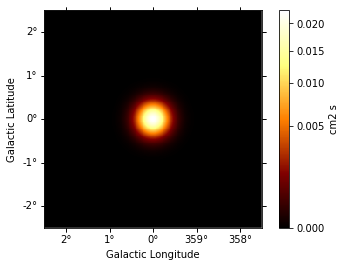

In [245]:
npred.plot_interactive(add_cbar=True, stretch="sqrt")

In [246]:
#npred.plot_interactive()

In [247]:
sampler = MapEventSampler(npred)
events=sampler.sample_npred()

In [248]:
events

lon_true,lat_true,e_true
deg,deg,TeV
float64,float64,float64
359.7333370969594,-0.07244496321415028,1.5217603637521027
359.85837797220023,0.20359207355119283,2.1419659842005205
359.8918551765717,-0.019506425432173274,5.622337036174219
359.7953553171566,-0.1186550073707349,1.7314521299420373
0.15735024730484043,0.2935878554699713,1.7356792123034828
359.9989314563643,-0.03092606310887902,1.7304144260407368
0.005488112715788418,-0.06926841577782568,1.206531807265262
359.7997714508275,0.17793342586080713,3.3898717477327427


### Sampling from the PSF

For the testing of the PSF sampling we read in an example PSF from the CTA first data challenge:

In [421]:
filename = "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
#filename = "/Users/fabio/LAVORO/CTA/DC/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
psf_gauss = EnergyDependentMultiGaussPSF.read(filename=filename, hdu="POINT SPREAD FUNCTION")
psf_3d = psf_gauss.to_psf3d(rad=np.linspace(0, 1, 100) * u.deg)
psf_map = make_psf_map(psf_3d, geom=geom_psf, pointing=geom_psf.center_skydir, max_offset=3 * u.deg)

From this we create a PSF map:

In [250]:
theta_axis = MapAxis.from_bounds(0, 0.5, nbin=100, unit="deg", name="theta")

geom_psf = WcsGeom.create(
    binsz=0.2,
    skydir=position,
    width="5 deg",
    axes=[theta_axis, energy_axis],
    coordsys="GAL"
)

In [251]:
psf_map = make_psf_map(psf_3d, geom=geom_psf, pointing=geom_psf.center_skydir, max_offset=3 * u.deg)

Now we look up the shape of the PSF at every true event position (in space and energy):

In [252]:
events.sort("e_true")
coord = {
    "lon": events["lon_true"].reshape(-1, 1),
    "lat": events["lat_true"].reshape(-1, 1),
    "energy": events["e_true"].quantity.reshape(-1, 1),
    "theta": (theta_axis.center * theta_axis.unit)
}

pdf = psf_map.psf_map.interp_by_coord(coord)

In [253]:
# plt.figure(figsize=(12, 4))
# plt.imshow(np.sqrt(pdf))
# plt.xlabel("Theta (pixels)")
# plt.ylabel("Event #")

Now we sample form the 2D PDF along the theta axis:

In [254]:
sample_pdf = InverseCDFSampler(pdf, axis=1)
pix_coord = sample_pdf.sample_axis()

offset = theta_axis.pix_to_coord(pix_coord)

In [255]:
# we apply the psf to the simulated events
#
sampler = MapEventSampler(npred,psf_map=pdf)
events=sampler.sample_npred()
events=sampler.apply_psf(events)
#events=sampler.apply_edisp(events)

In [256]:
events

lon_true,lat_true,e_true
deg,deg,TeV
float64,float64,float64
359.7567261796434,-0.04905588053016913,1.5217603637521027
359.8897280120662,0.172242033685232,2.1419659842005205
359.9205311466823,-0.04818239554278625,5.622337036174219
359.770544374431,-0.1434659500963221,1.7314521299420373
0.14110648158724065,0.2773440897523715,1.7356792123034828
359.9710506696922,-0.0588068497809682,1.7304144260407368
0.023448322372147615,-0.08722862543418487,1.206531807265262
359.7469101912985,0.2307946853897615,3.3898717477327427


A an additional check we sample from a point source at fixed energy:

In [111]:
N = 100000
energy = np.ones(N) * u.TeV
theta = (theta_axis.center * theta_axis.unit)

coord = {
    "lon": np.zeros(N).reshape(-1, 1),
    "lat": np.zeros(N).reshape(-1, 1),
    "energy": energy.reshape(-1, 1),
    "theta": theta
    
}

pdf = psf_map.psf_map.interp_by_coord(coord)

In [112]:
sample_pdf = InverseCDFSampler(pdf, axis=1)
pix_coord = sample_pdf.sample_axis()
coords = theta_axis.pix_to_coord(pix_coord)

In [115]:
coords

array([0.02267629, 0.03452022, 0.02751198, ..., 0.04107312, 0.02147888,
       0.00921252])

This what the CDF looks like:

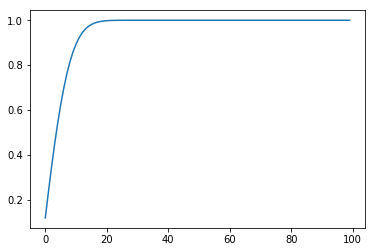

In [113]:
plt.plot(sample_pdf.cdf[0])

Let's check the histogram against the analytical PDF:

(0, 0.2)

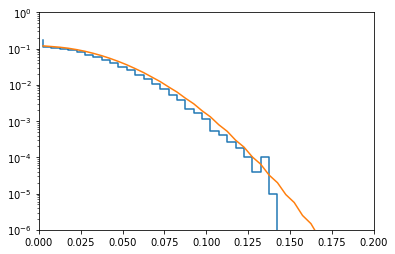

In [114]:
psf_value = psf_3d.evaluate(energy=1 * u.TeV, offset=0 * u.deg, rad=theta)
psf_value = psf_value / psf_value.sum()

psf_hist, vals = np.histogram(coords, theta_axis.edges)
plt.step(theta, psf_hist / psf_hist.sum());
plt.plot(theta, psf_value.squeeze())
plt.semilogy()
plt.ylim(1e-6, 1)
plt.xlim(0, 0.2)

### Sampling from the Edisp

For the testing of the Edisp sampling we read in an example Edisp from the CTA first data challenge:

In [271]:
edisp2D = EnergyDispersion2D.read(filename=filename, hdu="ENERGY DISPERSION")

In [328]:
energy = EnergyBounds.equal_log_spacing(0.1,100,100, 'TeV')
edisp = edisp2D.to_energy_dispersion(offset='0.0 deg', e_reco=energy, e_true=energy)

In [329]:
np.shape(edisp.data.data)

(100, 100)

### Sampling the BKG

For the testing of the background, we read in an example background from the CTA first data challenge:

In [425]:
from gammapy.irf import load_cta_irfs
filename = (
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)
irfs = load_cta_irfs(filename)
axis = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0), binsz=0.02, width=(5, 4), coordsys="GAL", axes=[axis]
)
pointing = SkyCoord(1, 0.5, unit="deg", frame="galactic")
livetime = 1 * u.hour
offset_max = 2 * u.deg
offset = Angle("2 deg")
background = make_map_background_irf(
    pointing=pointing, ontime=livetime, bkg=irfs["bkg"], geom=geom
)

AttributeError: 'SkyCoord' object has no attribute 'altaz_frame'

In [409]:
print(irfs['bkg'])

Background3D
NDDataArray summary info
energy         : size =    21, min =  0.016 TeV, max = 158.489 TeV
fov_lon        : size =    36, min = -5.833 deg, max =  5.833 deg
fov_lat        : size =    36, min = -5.833 deg, max =  5.833 deg
Data           : size = 27216, min =  0.000 1 / (MeV s sr), max =  0.421 1 / (MeV s sr)



In [414]:
bkg = Background3D.read(filename=filename)
livetime = 10 * u.hour

In [420]:
print(position)

<SkyCoord (Galactic): (l, b) in deg
    (0., 0.)>


In [416]:
bkg.data

In [418]:
make_map_background_irf(pointing=position, ontime=livetime, bkg=irfs['bkg'], geom=geom)

In [419]:
#print(bkg.)

In [370]:
from gammapy.data import PointingInfo
pointing_info = PointingInfo.read('$GAMMAPY_DATA/tests/hess_event_list.fits')

position = SkyCoord(0.0, 0.0, frame='galactic', unit='deg')

wcs_geom = WcsGeom.create(
    binsz=0.02, width=(5, 5), skydir=pointing_info.radec[0], coordsys="GAL"
)
print(position)
#position.altaz(pointing_info.altaz[0]) 

<SkyCoord (Galactic): (l, b) in deg
    (0., 0.)>


In [387]:
print(pointing_info)

Pointing info:

Location:     GeodeticLocation(lon=<Longitude 16.50022222 deg>, lat=<Latitude -23.27177778 deg>, height=<Quantity 1835. m>)
MJDREFI, MJDREFF, TIMESYS = (51910, 0.000742870370370241, 'TT')
Time ref:     2001-01-01T00:01:04.184
Time ref:     51910.00074287037 MJD (TT)
Duration:     1586.0000000000018 sec = 0.44055555555555603 hours
Table length: 100

START:
Time:  2004-01-21T19:50:02.184
Time:  53025.826414166666 MJD (TT)
RADEC: 83.6333 24.5144 deg
ALTAZ: 11.4575 41.3409 deg


END:
Time:  2004-01-21T20:16:28.184
Time:  53025.844770648146 MJD (TT)
RADEC: 83.6333 24.5144 deg
ALTAZ: 3.44573 42.1319 deg




In [377]:
a=wcs_geom.to_image().get_coord()
b = a.skycoord

In [381]:
b.transform_to(pointing_info[0])

TypeError: 'PointingInfo' object does not support indexing

In [371]:

#make_map_background_irf(pointing=position, ontime=10000, bkg=bkg, geom=exposure)
make_map_background_irf(pointing=pointing_info, ontime=10000, bkg=bkg, geom=wcs_geom)

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: ()->() (250,250,3)->(250,250,newaxis) (250,250,3)->(250,250,newaxis) (100,3)->(100,newaxis) (100,)->(100,newaxis) ()->() and requested shape (3)

In [368]:
from gammapy.data import PointingInfo
pointing_info = PointingInfo.read('$GAMMAPY_DATA/tests/hess_event_list.fits')

In [369]:
print(pointing_info.radec[0])

<SkyCoord (ICRS): (ra, dec) in deg
    (83.63333333, 24.51444444)>
